# Tyre Quality Checker 🏍️🚗🛞🔧🧑‍🔧 with PyTorch 🔥

Vehicle tyres become obsolute as they age and rubber becomes hard. This causes minute cracks in the surface. I am attempting to create a predictor to identify whether a tyre is defective or good from images of the tyres.

## Download Data 🔽

Dataset attribution:
- Title: Tyre Quality Classification
- Author: CHIRAG CHAUHAN
- Source: [Kaggle](https://www.kaggle.com/datasets/warcoder/tyre-quality-classification)
- License: This dataset is licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0). 
- License URL: https://creativecommons.org/licenses/by/4.0/
    
Thanks for such an amazing, high quality dataset.

In [1]:
!pip install -q kaggle

In [3]:
# # run once
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d warcoder/tyre-quality-classification

100%|█████████████████████████████████████▉| 2.66G/2.66G [00:43<00:00, 45.9MB/s]
100%|██████████████████████████████████████| 2.66G/2.66G [00:43<00:00, 65.7MB/s]


In [5]:
!unzip -q tyre-quality-classification.zip 

## Data structure format to support ImageFolder 🗂️

In [12]:
import os
import shutil
import random

# Define the source and destination directories
source_directory = 'Digital images of defective and good condition tyres'
destination_directory = 'data'

In [13]:
train_dir = os.path.join(destination_directory, "train")
test_dir = os.path.join(destination_directory, "test")

train_dir, test_dir

('data/train', 'data/test')

In [14]:
# Create destination folders if they don't exist
os.makedirs(os.path.join(destination_directory, 'train', 'defective'), exist_ok=True)
os.makedirs(os.path.join(destination_directory, 'train', 'good'), exist_ok=True)
os.makedirs(os.path.join(destination_directory, 'test', 'defective'), exist_ok=True)
os.makedirs(os.path.join(destination_directory, 'test', 'good'), exist_ok=True)

# Function to copy images to train or test folders
def copy_images(source_folder, class_name, destination_directory):
    files = os.listdir(source_folder)
    random.shuffle(files)
    split_ratio = 0.8  # 80% for training, 20% for testing
    num_train = int(len(files) * split_ratio)
    train_files = files[:num_train]
    test_files = files[num_train:]

    for filename in train_files:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_directory, 'train', class_name, filename)
        shutil.copyfile(source_path, destination_path)

    for filename in test_files:
        source_path = os.path.join(source_folder, filename)
        destination_path = os.path.join(destination_directory, 'test', class_name, filename)
        shutil.copyfile(source_path, destination_path)

# Copy images from defective folder
copy_images(os.path.join(source_directory, 'defective'), 'defective', destination_directory)

# Copy images from good folder
copy_images(os.path.join(source_directory, 'good'), 'good', destination_directory)

## Imports and environment setup 🚂

In [16]:
# Getting modue
!rm -rf pytorch_mod
!git clone https://github.com/PaSathees/pytorch_mod.git

Cloning into 'pytorch_mod'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 198 (delta 50), reused 55 (delta 41), pack-reused 133
Receiving objects: 100% (198/198), 47.42 KiB | 94.00 KiB/s, done.
Resolving deltas: 100% (122/122), done.


In [17]:
pip install -r pytorch_mod/requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [18]:
from pytorch_mod import env_setup, data_setup, engine, evaluation, utils, visualization, experimentation, deployment

In [19]:
env_setup.print_gpu_status()

1 Supported CUDA GPU available


In [20]:
env_setup.print_versions()

PyTorch Version: 1.12.1+cu116
Matplotlib Version: 3.6.1
Pandas Version: 1.5.0
Numpy Version: 1.23.4
Torchvision Version: 0.13.1+cu116
Torchaudio Version: 0.12.1+cu116
Scikit-learn Version: 1.1.2
Torchmetrics Version: 1.2.0
TQDM Version: 4.64.1
MLEXTEND Version: 0.23.0
PIL Version: 9.2.0
Torchinfo Version: 1.8.0
Gradio Version: 3.50.2


In [21]:
import os
from PIL import Image
import shutil
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torchinfo import summary

In [22]:
device = env_setup.get_agnostic_device()
device

'cuda'

## Transfer learning experimentation 🔬🧪 with PyTorch Pre-trained models - TRIAL 🧭 0
Pre-trained Models to try:
1. [EFFICIENTNET_V2_L](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_l.html#efficientnet-v2-l)
2. [EFFICIENTNET_V2_M](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_m.html#torchvision.models.EfficientNet_V2_M_Weights)
3. [CONVNEXT_BASE](https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_base.html#torchvision.models.ConvNeXt_Base_Weights)
4. [VIT_B_16](https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights)
5. [WIDE_RESNET101_2](https://pytorch.org/vision/main/models/generated/torchvision.models.wide_resnet101_2.html#torchvision.models.Wide_ResNet101_2_Weights)
6. [RESNEXT101_64X4D](https://pytorch.org/vision/main/models/generated/torchvision.models.resnext101_64x4d.html#torchvision.models.ResNeXt101_64X4D_Weights)

Let's use MLFlow to track experiments

In [56]:
!pip install -q mlflow
!pip install -q pyngrok

__!Restart Runtime__

In [57]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [58]:
# MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
# subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])
subprocess.Popen(["mlflow", "ui"])

<Popen: returncode: None args: ['mlflow', 'ui']>

In [59]:
# mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# mlflow will create an experiment if it doesn't exist
mlflow.set_experiment("Tyre-quality-transfer-learning-tracking")

<Experiment: artifact_location='file:///notebooks/mlruns/297154745823662428', creation_time=1698436963535, experiment_id='297154745823662428', last_update_time=1698436963535, lifecycle_stage='active', name='Tyre-quality-transfer-learning-tracking', tags={}>

In [60]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth


[2023-10-27 22:20:27 +0000] [6331] [INFO] Starting gunicorn 21.2.0
[2023-10-27 22:20:27 +0000] [6331] [INFO] Listening at: http://127.0.0.1:5000 (6331)
[2023-10-27 22:20:27 +0000] [6331] [INFO] Using worker: sync
[2023-10-27 22:20:27 +0000] [6332] [INFO] Booting worker with pid: 6332
[2023-10-27 22:20:27 +0000] [6333] [INFO] Booting worker with pid: 6333
[2023-10-27 22:20:27 +0000] [6334] [INFO] Booting worker with pid: 6334
[2023-10-27 22:20:27 +0000] [6335] [INFO] Booting worker with pid: 6335


 ········


t=2023-10-27T22:20:35+0000 lvl=warn msg="ngrok config file found at legacy location, move to XDG location" xdg_path=/root/.config/ngrok/ngrok.yml legacy_path=/root/.ngrok2/ngrok.yml


 * ngrok tunnel "https://3b9d-172-83-13-4.ngrok-free.app" -> "http://127.0.0.1:5000"


### 1. EFFICIENTNET_V2_L

In [28]:
def train_efficientnet_v2_l(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"EFFICIENTNET_V2_L-trial-{trial}")

        # Constants
        ARCH_NAME = "EfficientNet_V2_L"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.features.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.classifier = torch.nn.Sequential(
          torch.nn.Dropout(p=0.2, inplace=True),
          torch.nn.Linear(in_features=1280,
                          out_features=1,
                          bias=True),
          torch.nn.Sigmoid()
        ).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4574 | Train_acc: 0.8086 | Val_loss: 0.3181 | Val_acc: 0.9140
[INFO] Epoch: 2 | Train_loss: 0.2843 | Train_acc: 0.8989 | Val_loss: 0.2416 | Val_acc: 0.9355
[INFO] Epoch: 3 | Train_loss: 0.2432 | Train_acc: 0.9124 | Val_loss: 0.2046 | Val_acc: 0.9462
[INFO] Epoch: 4 | Train_loss: 0.2099 | Train_acc: 0.9265 | Val_loss: 0.1835 | Val_acc: 0.9489
[INFO] Epoch: 5 | Train_loss: 0.2031 | Train_acc: 0.9367 | Val_loss: 0.1639 | Val_acc: 0.9570
[INFO] Training time: 458.038 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_5_lr_0.001.pth


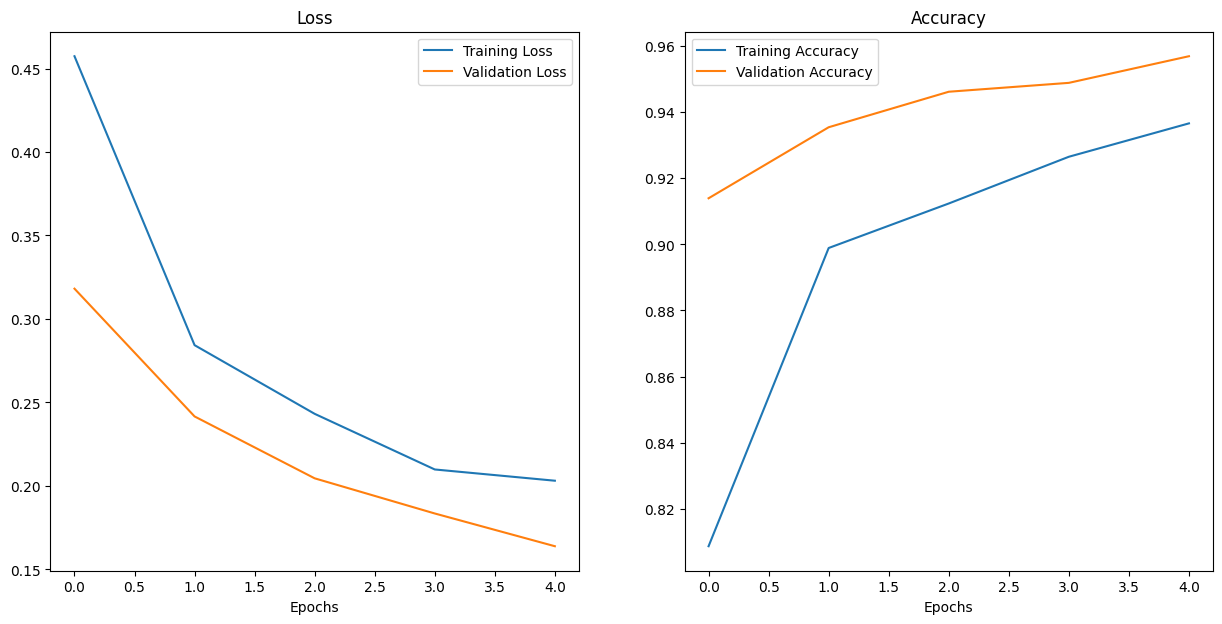

In [42]:
# 5 epochs
train_efficientnet_v2_l(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

### 2. EFFICIENTNET_V2_M

In [43]:
def train_efficientnet_v2_m(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"EFFICIENTNET_V2_M-trial-{trial}")

        # Constants
        ARCH_NAME = "EfficientNet_V2_M"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_m(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.features.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.classifier = torch.nn.Sequential(
          torch.nn.Dropout(p=0.2, inplace=True),
          torch.nn.Linear(in_features=1280,
                          out_features=1,
                          bias=True),
          torch.nn.Sigmoid()
        ).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


  0%|          | 0.00/208M [00:00<?, ?B/s]

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.5190 | Train_acc: 0.7803 | Val_loss: 0.4244 | Val_acc: 0.8441
[INFO] Epoch: 2 | Train_loss: 0.3686 | Train_acc: 0.8686 | Val_loss: 0.3522 | Val_acc: 0.8763
[INFO] Epoch: 3 | Train_loss: 0.3106 | Train_acc: 0.8854 | Val_loss: 0.3138 | Val_acc: 0.8737
[INFO] Epoch: 4 | Train_loss: 0.2858 | Train_acc: 0.8908 | Val_loss: 0.2999 | Val_acc: 0.8817
[INFO] Epoch: 5 | Train_loss: 0.2761 | Train_acc: 0.8881 | Val_loss: 0.2797 | Val_acc: 0.8817
[INFO] Training time: 346.140 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_M_bs_32_ep_5_lr_0.001.pth


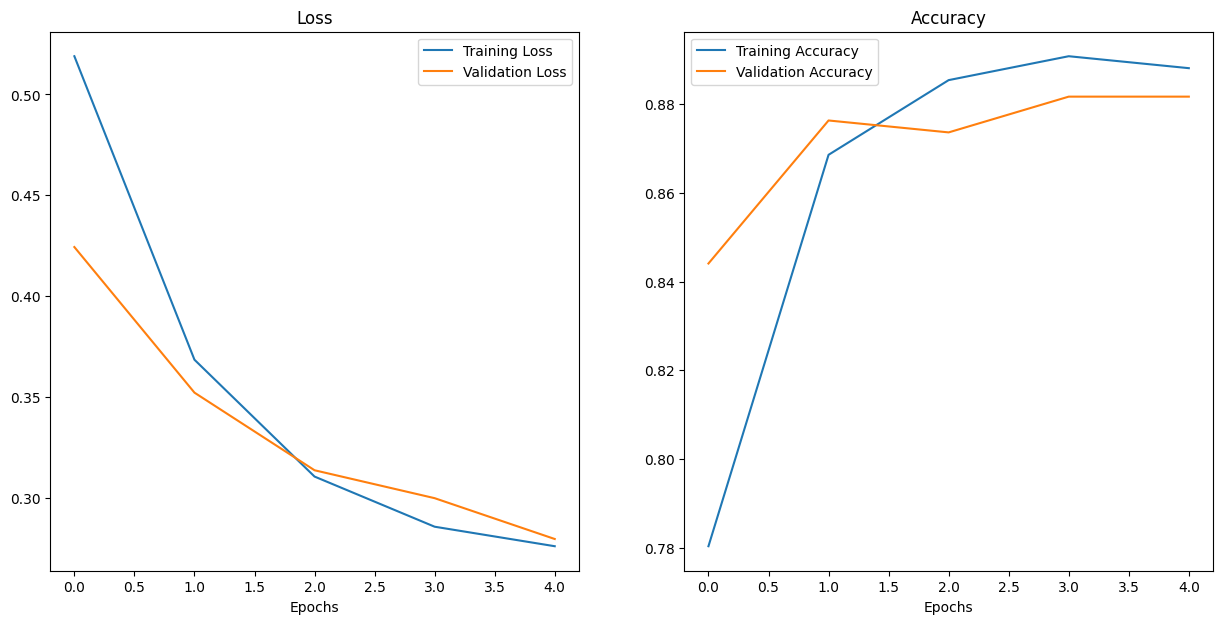

In [44]:
# 5 epochs
train_efficientnet_v2_m(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

### 3. CONVNEXT_BASE

In [45]:
def train_convnext_base(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"CONVNEXT_BASE-trial-{trial}")

        # Constants
        ARCH_NAME = "convnext_base"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.ConvNeXt_Base_Weights.DEFAULT
        model = torchvision.models.convnext_base(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.features.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.classifier[-1] = torch.nn.Linear(in_features=1024,
                                              out_features=1,
                                              bias=True).to(device)
        model.classifier.add_module("sigmoid", torch.nn.Sigmoid().to(device))

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


  0%|          | 0.00/338M [00:00<?, ?B/s]

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4327 | Train_acc: 0.8329 | Val_loss: 0.3054 | Val_acc: 0.8844
[INFO] Epoch: 2 | Train_loss: 0.2581 | Train_acc: 0.9090 | Val_loss: 0.2420 | Val_acc: 0.9059
[INFO] Epoch: 3 | Train_loss: 0.2153 | Train_acc: 0.9158 | Val_loss: 0.2082 | Val_acc: 0.9194
[INFO] Epoch: 4 | Train_loss: 0.1823 | Train_acc: 0.9306 | Val_loss: 0.1906 | Val_acc: 0.9167
[INFO] Epoch: 5 | Train_loss: 0.1672 | Train_acc: 0.9394 | Val_loss: 0.1696 | Val_acc: 0.9301
[INFO] Training time: 223.922 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_convnext_base_bs_32_ep_5_lr_0.001.pth


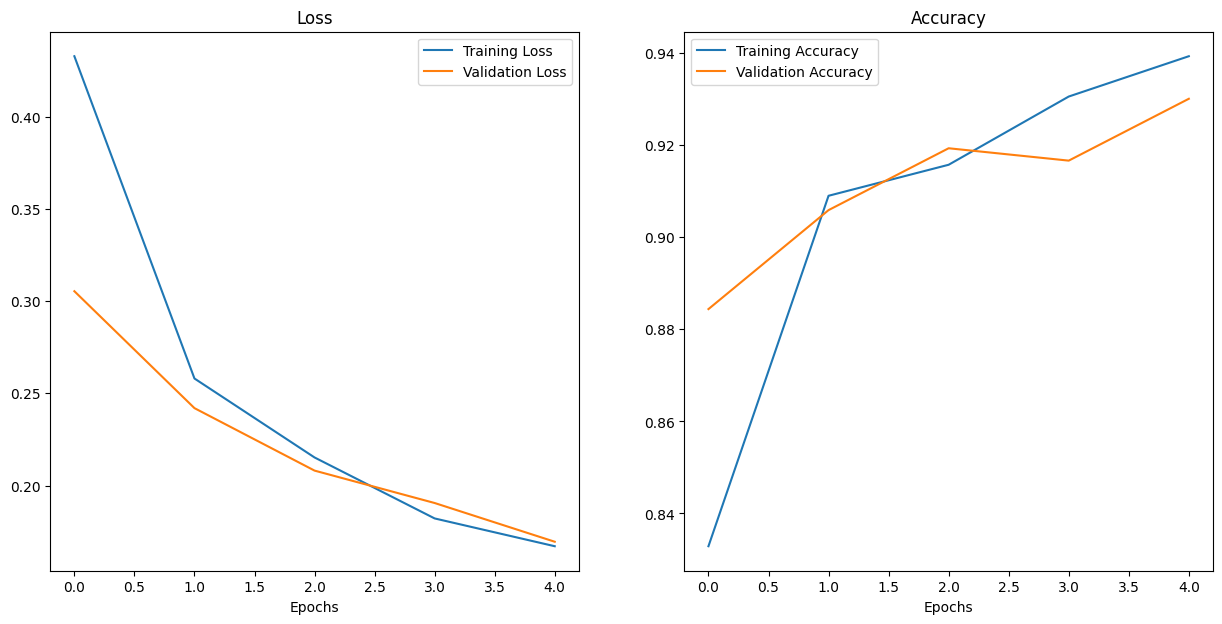

In [46]:
# 5 epochs
train_convnext_base(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

### 4. VIT_B_16

In [47]:
def train_vit_b_16(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"VIT_B_16-trial-{trial}")

        # Constants
        ARCH_NAME = "vit_b_16"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.ViT_B_16_Weights.DEFAULT
        model = torchvision.models.vit_b_16(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.heads = torch.nn.Sequential(
          torch.nn.Linear(in_features=768, out_features=1, bias=True),
          torch.nn.Sigmoid()).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4263 | Train_acc: 0.8214 | Val_loss: 0.3052 | Val_acc: 0.8844
[INFO] Epoch: 2 | Train_loss: 0.2639 | Train_acc: 0.8949 | Val_loss: 0.2461 | Val_acc: 0.8978
[INFO] Epoch: 3 | Train_loss: 0.2186 | Train_acc: 0.9171 | Val_loss: 0.2178 | Val_acc: 0.9086
[INFO] Epoch: 4 | Train_loss: 0.1884 | Train_acc: 0.9292 | Val_loss: 0.1976 | Val_acc: 0.9167
[INFO] Epoch: 5 | Train_loss: 0.1711 | Train_acc: 0.9367 | Val_loss: 0.1818 | Val_acc: 0.9220
[INFO] Training time: 240.880 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_vit_b_16_bs_32_ep_5_lr_0.001.pth


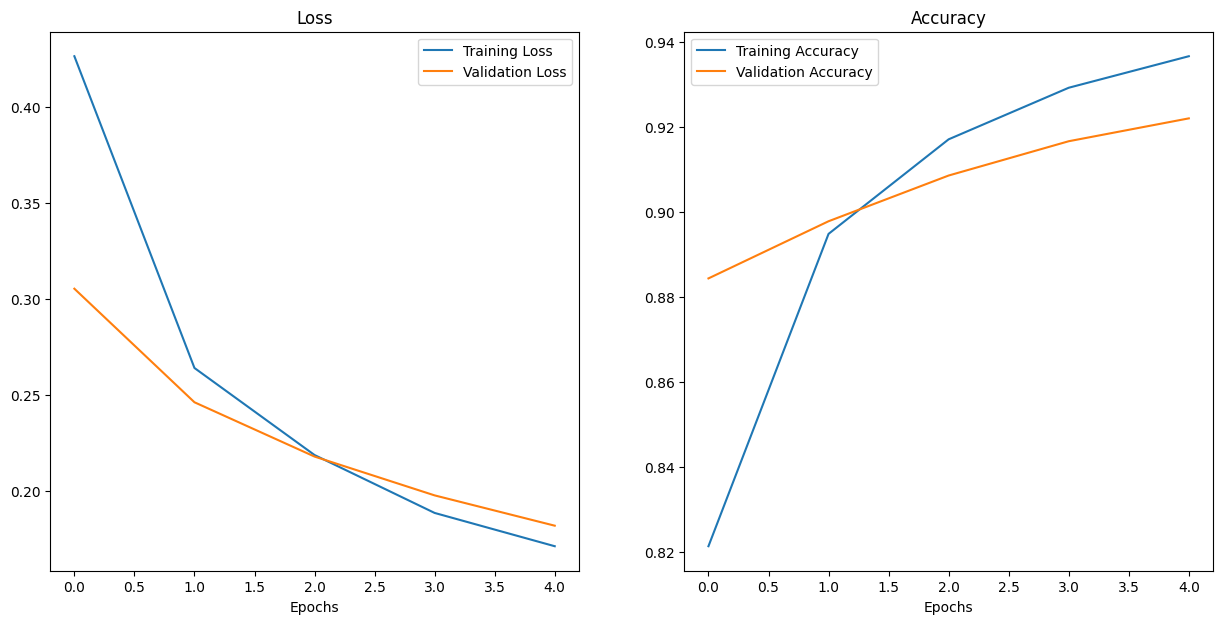

In [48]:
# 5 epochs
train_vit_b_16(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

### 5. WIDE_RESNET101_2

In [56]:
def train_wide_resnet101_2(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"WIDE_RESNET101_2-trial-{trial}")

        # Constants
        ARCH_NAME = "wide_resnet101_2"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.Wide_ResNet101_2_Weights.DEFAULT
        model = torchvision.models.wide_resnet101_2(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=2048, out_features=1, bias=True),
          torch.nn.Sigmoid()).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4618 | Train_acc: 0.8201 | Val_loss: 0.3909 | Val_acc: 0.8548
[INFO] Epoch: 2 | Train_loss: 0.3172 | Train_acc: 0.8848 | Val_loss: 0.3243 | Val_acc: 0.8763
[INFO] Epoch: 3 | Train_loss: 0.2704 | Train_acc: 0.8935 | Val_loss: 0.2714 | Val_acc: 0.9194
[INFO] Epoch: 4 | Train_loss: 0.2394 | Train_acc: 0.9124 | Val_loss: 0.2607 | Val_acc: 0.9032
[INFO] Epoch: 5 | Train_loss: 0.2207 | Train_acc: 0.9218 | Val_loss: 0.2373 | Val_acc: 0.9220
[INFO] Training time: 215.413 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_wide_resnet101_2_bs_32_ep_5_lr_0.001.pth


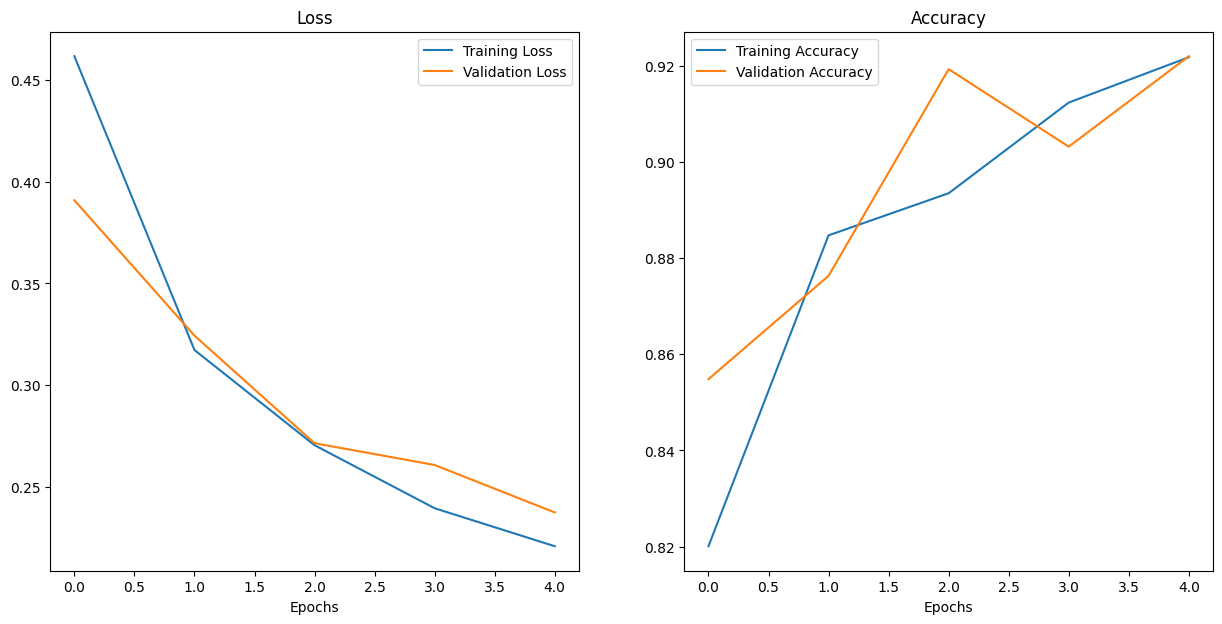

In [57]:
# 5 epochs
train_wide_resnet101_2(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

### 6. RESNEXT101_64X4D

In [58]:
def train_resnext101_64x4d(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"RESNEXT101_64X4D-trial-{trial}")

        # Constants
        ARCH_NAME = "resnext101_64x4d"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.ResNeXt101_64X4D_Weights.DEFAULT
        model = torchvision.models.resnext101_64x4d(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=2048, out_features=1, bias=True),
          torch.nn.Sigmoid()).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth


  0%|          | 0.00/319M [00:00<?, ?B/s]

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.5703 | Train_acc: 0.7635 | Val_loss: 0.5074 | Val_acc: 0.8468
[INFO] Epoch: 2 | Train_loss: 0.4215 | Train_acc: 0.8801 | Val_loss: 0.4149 | Val_acc: 0.8548
[INFO] Epoch: 3 | Train_loss: 0.3530 | Train_acc: 0.8895 | Val_loss: 0.3674 | Val_acc: 0.8790
[INFO] Epoch: 4 | Train_loss: 0.3124 | Train_acc: 0.8996 | Val_loss: 0.3524 | Val_acc: 0.8844
[INFO] Epoch: 5 | Train_loss: 0.2841 | Train_acc: 0.9144 | Val_loss: 0.3215 | Val_acc: 0.8898
[INFO] Training time: 238.248 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_resnext101_64x4d_bs_32_ep_5_lr_0.001.pth


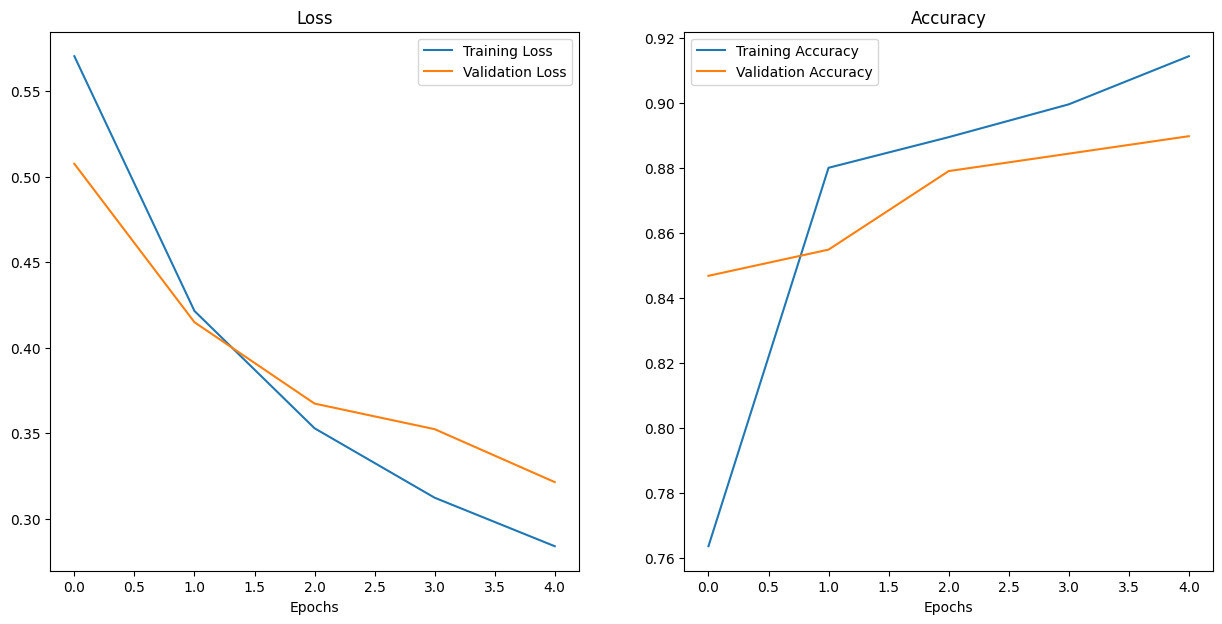

In [59]:
# 5 epochs
train_resnext101_64x4d(batch_size=32, learning_rate=0.001, epochs=5, train_dir=train_dir, test_dir=test_dir, trial=0)

In [60]:
# # Download MLFlow data
# import shutil
# from google.colab import files

# folder_path = '/content/mlruns'
# shutil.make_archive('/content/mlruns_27_10_2023', 'zip', folder_path)
# files.download('/content/mlruns_27_10_2023.zip')

## Scaling Up - further improvements
1. Try with increasing epochs
2. Try with Trivial Augmentation

### 1. Try with increasing epochs - TRIAL 🧭 1, 2

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth


  0%|          | 0.00/455M [00:00<?, ?B/s]

[INFO] Using device: cuda


  0%|          | 0/10 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4402 | Train_acc: 0.8248 | Val_loss: 0.3118 | Val_acc: 0.9059
[INFO] Epoch: 2 | Train_loss: 0.2845 | Train_acc: 0.9009 | Val_loss: 0.2418 | Val_acc: 0.9247
[INFO] Epoch: 3 | Train_loss: 0.2327 | Train_acc: 0.9191 | Val_loss: 0.2090 | Val_acc: 0.9301
[INFO] Epoch: 4 | Train_loss: 0.2168 | Train_acc: 0.9191 | Val_loss: 0.1882 | Val_acc: 0.9516
[INFO] Epoch: 5 | Train_loss: 0.2024 | Train_acc: 0.9205 | Val_loss: 0.1741 | Val_acc: 0.9543
[INFO] Epoch: 6 | Train_loss: 0.1826 | Train_acc: 0.9400 | Val_loss: 0.1624 | Val_acc: 0.9597
[INFO] Epoch: 7 | Train_loss: 0.1652 | Train_acc: 0.9434 | Val_loss: 0.1553 | Val_acc: 0.9597
[INFO] Epoch: 8 | Train_loss: 0.1822 | Train_acc: 0.9326 | Val_loss: 0.1481 | Val_acc: 0.9651
[INFO] Epoch: 9 | Train_loss: 0.1676 | Train_acc: 0.9441 | Val_loss: 0.1422 | Val_acc: 0.9597
[INFO] Epoch: 10 | Train_loss: 0.1590 | Train_acc: 0.9468 | Val_loss: 0.1411 | Val_acc: 0.9516
[INFO] Training time: 845.502 seconds


Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_10_lr_0.001.pth


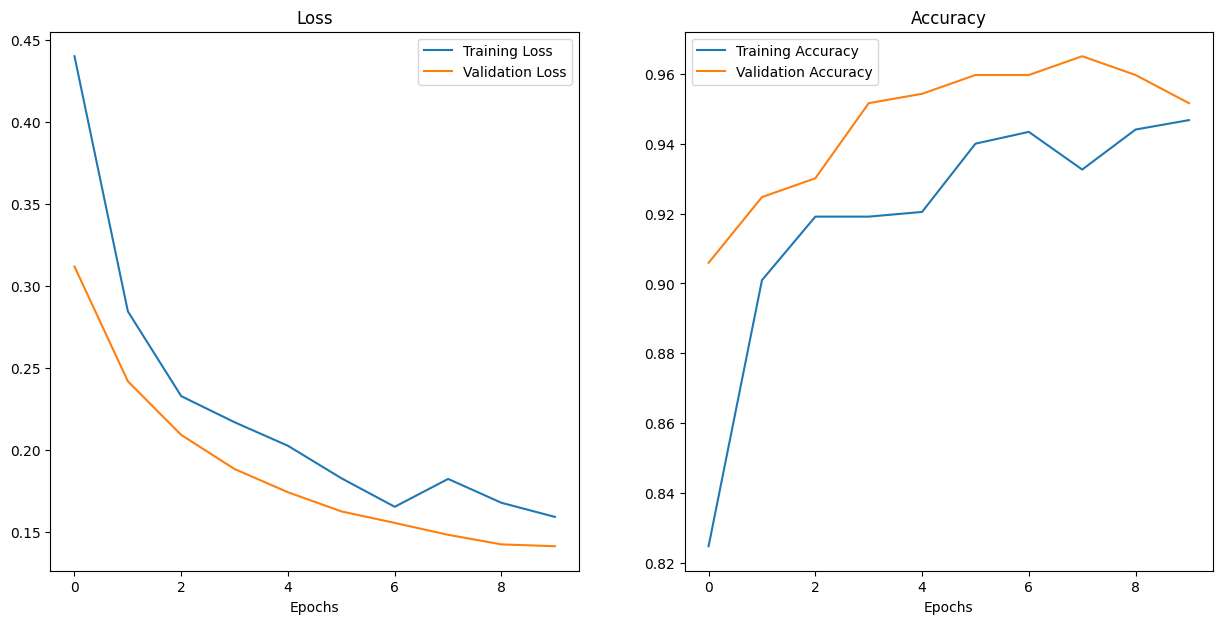

In [29]:
# 10 epochs
train_efficientnet_v2_l(batch_size=32, learning_rate=0.001, epochs=10, train_dir=train_dir, test_dir=test_dir, trial=1)

[INFO] Using device: cuda


  0%|          | 0/15 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4402 | Train_acc: 0.8248 | Val_loss: 0.3118 | Val_acc: 0.9059
[INFO] Epoch: 2 | Train_loss: 0.2845 | Train_acc: 0.9009 | Val_loss: 0.2418 | Val_acc: 0.9247
[INFO] Epoch: 3 | Train_loss: 0.2327 | Train_acc: 0.9191 | Val_loss: 0.2090 | Val_acc: 0.9301
[INFO] Epoch: 4 | Train_loss: 0.2168 | Train_acc: 0.9191 | Val_loss: 0.1882 | Val_acc: 0.9516
[INFO] Epoch: 5 | Train_loss: 0.2024 | Train_acc: 0.9205 | Val_loss: 0.1741 | Val_acc: 0.9543
[INFO] Epoch: 6 | Train_loss: 0.1826 | Train_acc: 0.9400 | Val_loss: 0.1624 | Val_acc: 0.9597
[INFO] Epoch: 7 | Train_loss: 0.1652 | Train_acc: 0.9434 | Val_loss: 0.1553 | Val_acc: 0.9597
[INFO] Epoch: 8 | Train_loss: 0.1822 | Train_acc: 0.9326 | Val_loss: 0.1481 | Val_acc: 0.9651
[INFO] Epoch: 9 | Train_loss: 0.1676 | Train_acc: 0.9441 | Val_loss: 0.1422 | Val_acc: 0.9597
[INFO] Epoch: 10 | Train_loss: 0.1590 | Train_acc: 0.9468 | Val_loss: 0.1411 | Val_acc: 0.9516
[INFO] Epoch: 11 | Train_loss: 0.1569 | Train_acc: 0.9468 |

Making Predictions:   0%|          | 0/12 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_15_lr_0.001.pth


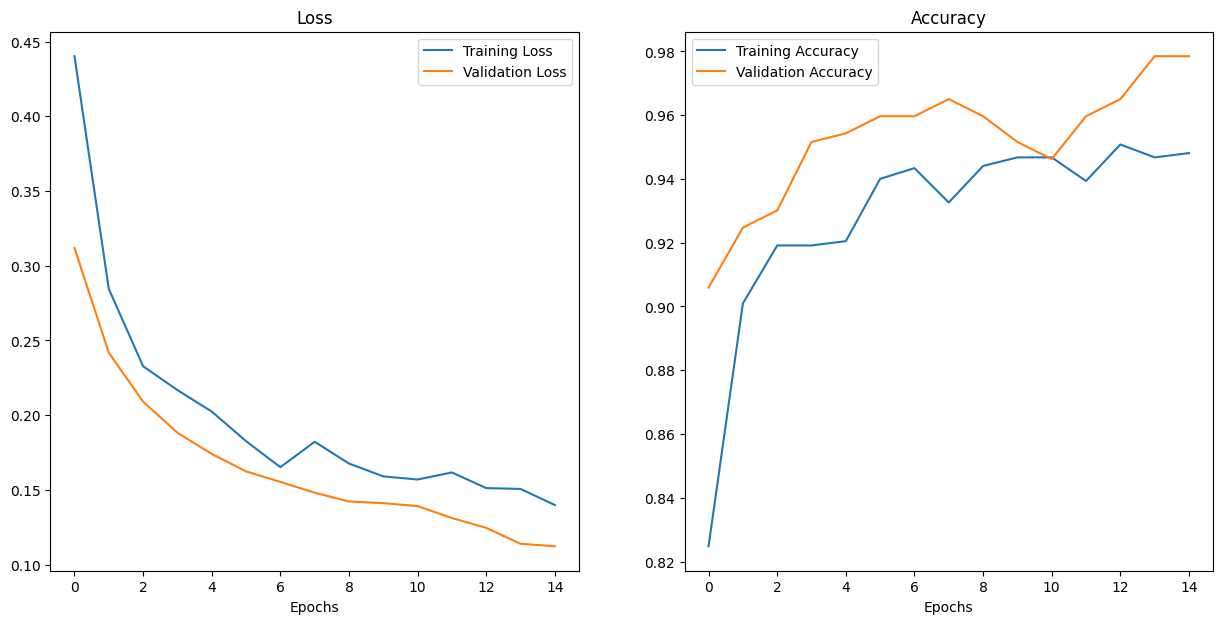

In [30]:
# 15 epochs
train_efficientnet_v2_l(batch_size=32, learning_rate=0.001, epochs=15, train_dir=train_dir, test_dir=test_dir, trial=2)

### 2. Try with Trivial Augmentation - TRIAL 🧭 3
Image data augmentation technique: https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

In [31]:
def train_efficientnet_v2_l_augment(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"EFFICIENTNET_V2_L-trial-{trial}")

        # Constants
        ARCH_NAME = "EfficientNet_V2_L_TrivialAugmentWide"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Combine trivial augmentation with pretrained_transforms
        combined_transforms = transforms.Compose([
          transforms.TrivialAugmentWide(num_magnitude_bins=31),
          auto_transforms
        ])

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=combined_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.features.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.classifier = torch.nn.Sequential(
          torch.nn.Dropout(p=0.2, inplace=True),
          torch.nn.Linear(in_features=1280,
                          out_features=1,
                          bias=True),
          torch.nn.Sigmoid()
        ).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                            train_dataloader=train_dataloader,
                            val_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=epochs,
                            device=device,
                            problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                        target_directory="models",
                                        save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)
    
        return model, class_names, test_dataloader, auto_transforms, combined_transforms

## Comparisons 📊

Lets compare parameters, architectures, pretrained models with MLFlow. I am using following metrics to select final model for deployment.
1. Test accuracy
2. Test loss

Trial results:

- Trial 1: EFFICIENTNET_V2_L seems to be doing well.

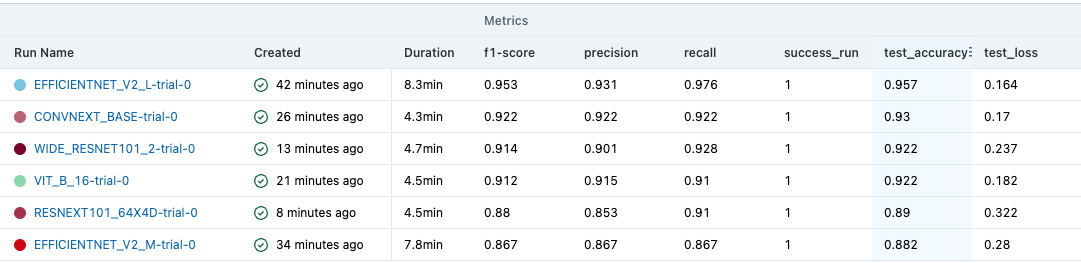

---------------------------------------------------------------------------

- Trial 2: Increasing epochs seems to help.

- Trial 3: Trivial Augmentation doesn't seem to improve results as expected.

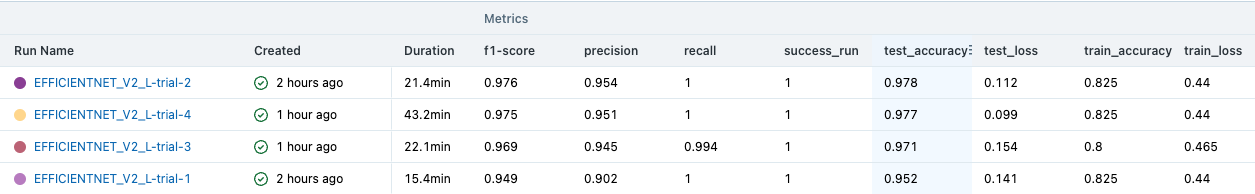

---------------------------------------------------------------------------

- Trial 4: We will scale results for a single big model 📈

[INFO] Using device: cuda


  0%|          | 0/15 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4652 | Train_acc: 0.7999 | Val_loss: 0.3956 | Val_acc: 0.9013
[INFO] Epoch: 2 | Train_loss: 0.3197 | Train_acc: 0.8915 | Val_loss: 0.3201 | Val_acc: 0.9143
[INFO] Epoch: 3 | Train_loss: 0.2660 | Train_acc: 0.9043 | Val_loss: 0.2785 | Val_acc: 0.9221
[INFO] Epoch: 4 | Train_loss: 0.2486 | Train_acc: 0.9023 | Val_loss: 0.2592 | Val_acc: 0.9351
[INFO] Epoch: 5 | Train_loss: 0.2393 | Train_acc: 0.8989 | Val_loss: 0.2486 | Val_acc: 0.9506
[INFO] Epoch: 6 | Train_loss: 0.2165 | Train_acc: 0.9205 | Val_loss: 0.2177 | Val_acc: 0.9506
[INFO] Epoch: 7 | Train_loss: 0.2048 | Train_acc: 0.9252 | Val_loss: 0.1988 | Val_acc: 0.9506
[INFO] Epoch: 8 | Train_loss: 0.2190 | Train_acc: 0.9191 | Val_loss: 0.2041 | Val_acc: 0.9558
[INFO] Epoch: 9 | Train_loss: 0.2103 | Train_acc: 0.9259 | Val_loss: 0.1893 | Val_acc: 0.9532
[INFO] Epoch: 10 | Train_loss: 0.1932 | Train_acc: 0.9292 | Val_loss: 0.1734 | Val_acc: 0.9558
[INFO] Epoch: 11 | Train_loss: 0.1982 | Train_acc: 0.9245 |

Making Predictions:   0%|          | 0/13 [00:01<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_L_TrivialAugmentWide_bs_32_ep_15_lr_0.001.pth


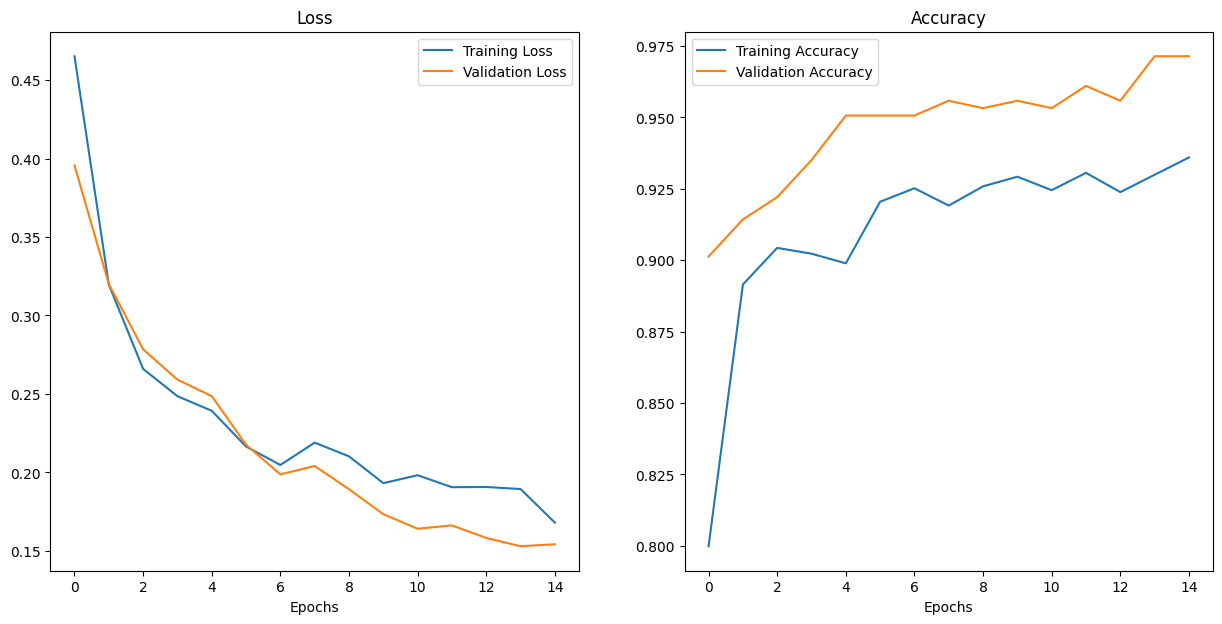

In [32]:
# TrivialAugmentWide, 15 epochs
augment_model, class_names, test_dataloader, auto_transforms, combined_transforms = train_efficientnet_v2_l_augment(batch_size=32, 
                                                                                                                    learning_rate=0.001, 
                                                                                                                    epochs=15, 
                                                                                                                    train_dir=train_dir, 
                                                                                                                    test_dir=test_dir, 
                                                                                                                    trial=3)

## Train Final model - TRIAL 🧭 4
This model will be used for deployment
1. Train a single large model
2. Evaluate this final single model

### 1. Train a single model

In [35]:
def train_efficientnet_v2_l(batch_size=32, learning_rate=0.001, epochs=1, train_dir="data/train", test_dir="data/test", trial=0):
    with mlflow.start_run():
        # Run name
        mlflow.set_tag("mlflow.runName", f"EFFICIENTNET_V2_L-trial-{trial}")

        # Constants
        ARCH_NAME = "EfficientNet_V2_L"
        MODEL_NAME = f"pt_tyre_quality_{ARCH_NAME}_bs_{batch_size}_ep_{epochs}_lr_{learning_rate}.pth"

        mlflow.set_tag("engineer", "Sathees")

        # Getting pre-trained model
        weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
        model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)

        # Get transforms
        auto_transforms = weights.transforms()

        # Dataloaders
        train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                                        test_dir=test_dir,
                                                                                        train_transform=auto_transforms,
                                                                                        test_transform=auto_transforms,
                                                                                        batch_size=batch_size)


        # Freeze features
        for param in model.features.parameters():
            param.requires_grad = False

        # Changing head
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)

        model.classifier = torch.nn.Sequential(
          torch.nn.Dropout(p=0.2, inplace=True),
          torch.nn.Linear(in_features=1280,
                          out_features=1,
                          bias=True),
          torch.nn.Sigmoid()
        ).to(device)

        # Loss and Optimizer
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        utils.set_seeds()
        results = engine.train(model=model,
                                train_dataloader=train_dataloader,
                                val_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=epochs,
                                device=device,
                                problem_type="binary")

        # Plot curves
        visualization.plot_curves(results)

        # Model evaluation
        ev = evaluation.evaluate_model_metrics(
            model=model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=loss_fn,
            device=device,
            plot_confusion=False
        )

        # Saving model
        deployment.save_model_to_directory(model=model,
                                            target_directory="models",
                                            save_name=MODEL_NAME)

        # Logging parameters & metrics
        mlflow.set_tag("architecture", ARCH_NAME)
        mlflow.log_param('batch_size', batch_size)
        mlflow.log_param('learning_rate', learning_rate)
        mlflow.log_param('epochs', epochs)
        mlflow.log_param("model-location", "models/"+MODEL_NAME)

        mlflow.log_metric("train_accuracy", results[0]["train_acc"][0])
        mlflow.log_metric("train_loss", results[0]["train_loss"][0])
        mlflow.log_metric("test_accuracy", ev["model_acc"])
        mlflow.log_metric("test_loss", ev["model_loss"])
        mlflow.log_metric("precision", ev["model_precision"])
        mlflow.log_metric("recall", ev["model_recall"])
        mlflow.log_metric("f1-score", ev["model_fl_score"])
        mlflow.log_metric("train_time", results[1])
        mlflow.log_metric("success_run", 1)
        
        return model, class_names, test_dataloader, auto_transforms

[INFO] Using device: cuda


  0%|          | 0/30 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 0.4402 | Train_acc: 0.8248 | Val_loss: 0.3854 | Val_acc: 0.8961
[INFO] Epoch: 2 | Train_loss: 0.2845 | Train_acc: 0.9009 | Val_loss: 0.3142 | Val_acc: 0.9169
[INFO] Epoch: 3 | Train_loss: 0.2327 | Train_acc: 0.9191 | Val_loss: 0.2751 | Val_acc: 0.9221
[INFO] Epoch: 4 | Train_loss: 0.2168 | Train_acc: 0.9191 | Val_loss: 0.2526 | Val_acc: 0.9429
[INFO] Epoch: 5 | Train_loss: 0.2024 | Train_acc: 0.9205 | Val_loss: 0.2328 | Val_acc: 0.9455
[INFO] Epoch: 6 | Train_loss: 0.1826 | Train_acc: 0.9400 | Val_loss: 0.2162 | Val_acc: 0.9506
[INFO] Epoch: 7 | Train_loss: 0.1652 | Train_acc: 0.9434 | Val_loss: 0.1927 | Val_acc: 0.9584
[INFO] Epoch: 8 | Train_loss: 0.1822 | Train_acc: 0.9326 | Val_loss: 0.2012 | Val_acc: 0.9610
[INFO] Epoch: 9 | Train_loss: 0.1676 | Train_acc: 0.9441 | Val_loss: 0.1826 | Val_acc: 0.9584
[INFO] Epoch: 10 | Train_loss: 0.1590 | Train_acc: 0.9468 | Val_loss: 0.1720 | Val_acc: 0.9506
[INFO] Epoch: 11 | Train_loss: 0.1569 | Train_acc: 0.9468 |

Making Predictions:   0%|          | 0/13 [00:00<?, ?it/s]

[INFO] Model saved to: models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth


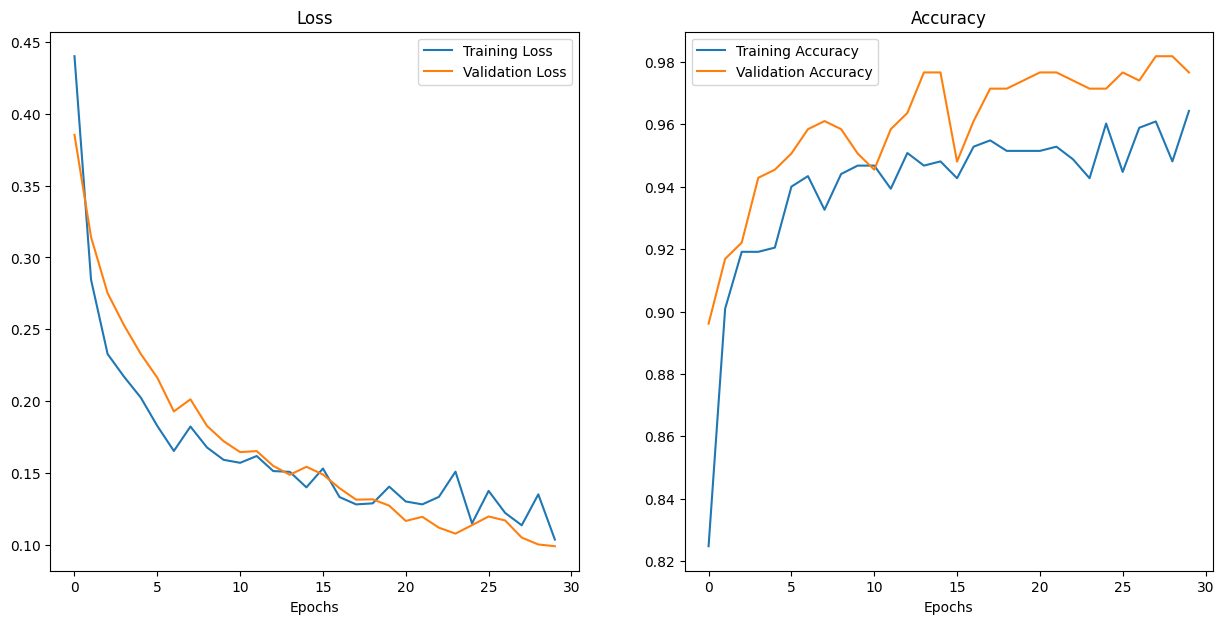

In [36]:
# 30 epochs
final_model, class_names, test_dataloader, auto_transforms = train_efficientnet_v2_l(batch_size=32, 
                                                                                    learning_rate=0.001, 
                                                                                    epochs=30, 
                                                                                    train_dir=train_dir, 
                                                                                    test_dir=test_dir, 
                                                                                    trial=4)

### 2. Evaluate this final single model

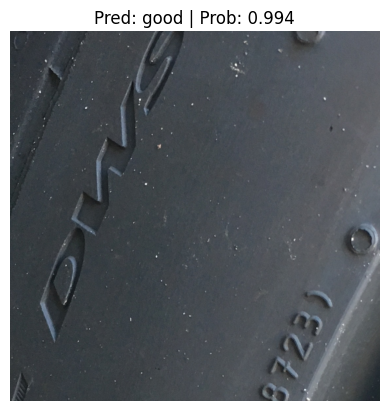

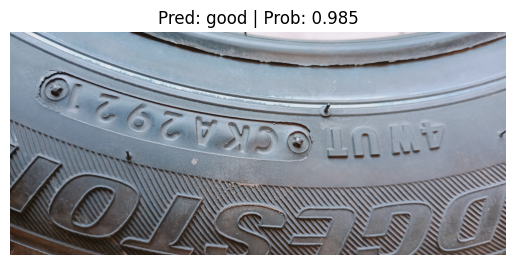

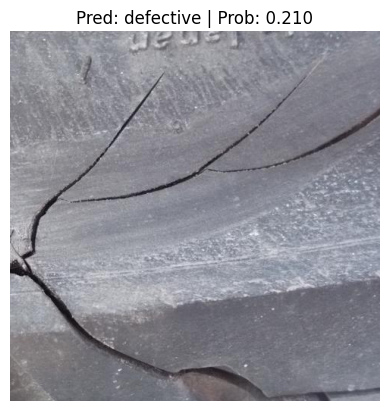

In [37]:
evaluation.pred_and_plot_local_random_images(model=final_model,
                                                test_dir_path=test_dir,
                                                class_names=class_names,
                                                transform=auto_transforms,
                                                image_extension=".jpg",
                                                device=device,
                                                multiclass=False)

In [39]:
ev = evaluation.evaluate_classification_report(
    model=final_model,
    test_dataloader=test_dataloader,
    device=device,
    class_names=class_names,
    task="binary"
)

print(ev)

Making Predictions:   0%|          | 0/13 [00:01<?, ?it/s]

              precision    recall  f1-score   support

   defective       1.00      0.96      0.98       211
        good       0.95      1.00      0.97       174

    accuracy                           0.98       385
   macro avg       0.98      0.98      0.98       385
weighted avg       0.98      0.98      0.98       385



Making Predictions:   0%|          | 0/13 [00:00<?, ?it/s]

{'model_name': 'EfficientNet',
 'model_loss': 0.09882555902004242,
 'model_acc': 0.9766233563423157,
 'model_precision': 0.9508196711540222,
 'model_recall': 1.0,
 'model_fl_score': 0.9747899174690247,
 'model_confusion_matrix': array([[202,   9],
        [  0, 174]])}

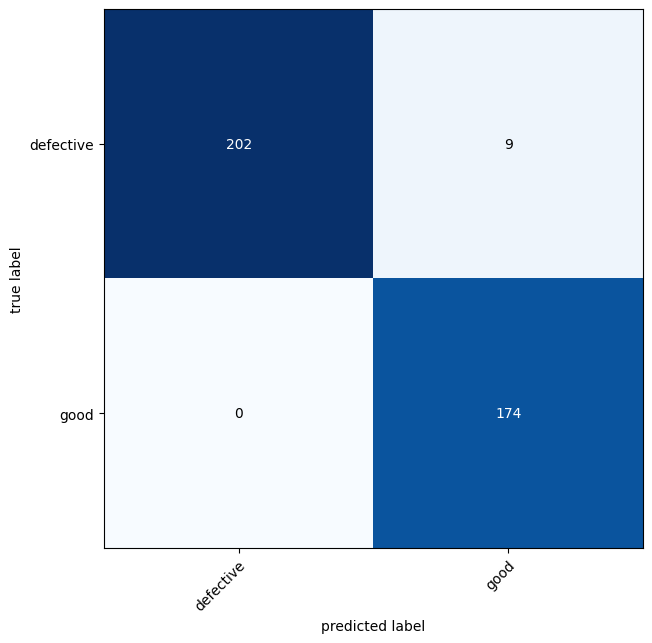

In [43]:
evaluation.evaluate_model_metrics(
            model=final_model,
            test_dataloader=test_dataloader,
            class_names=class_names,
            task="binary",
            loss_fn=nn.BCELoss(),
            device=device
        )

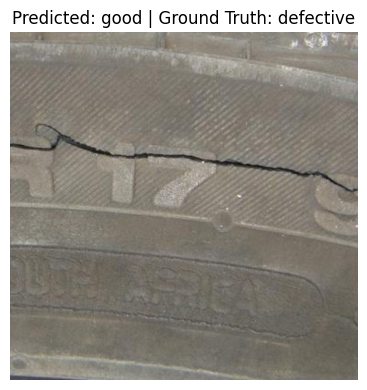

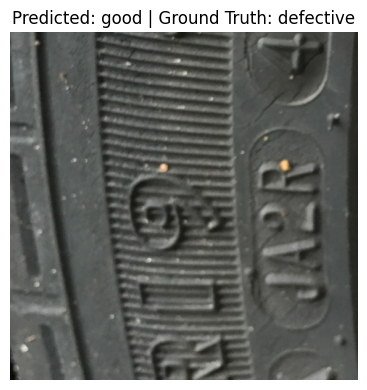

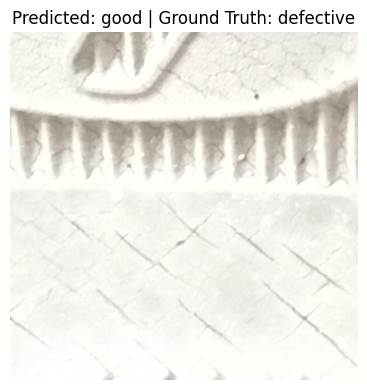

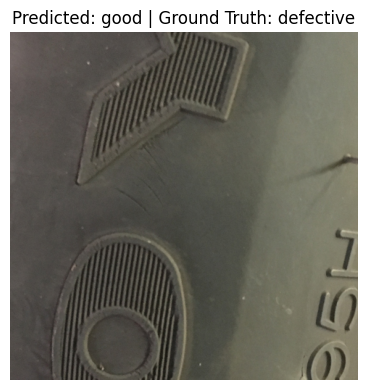

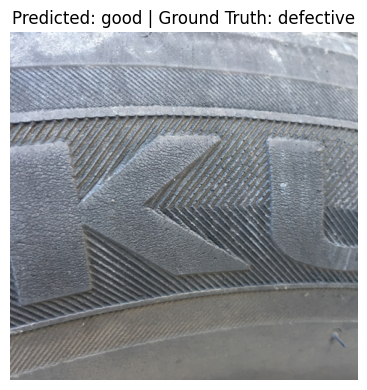

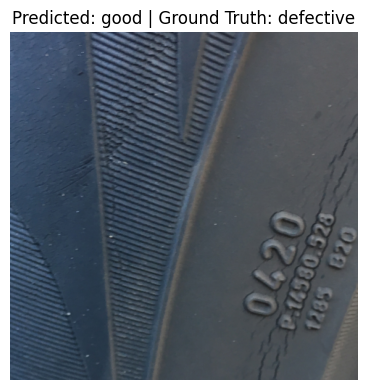

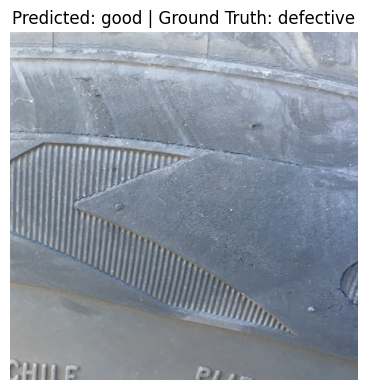

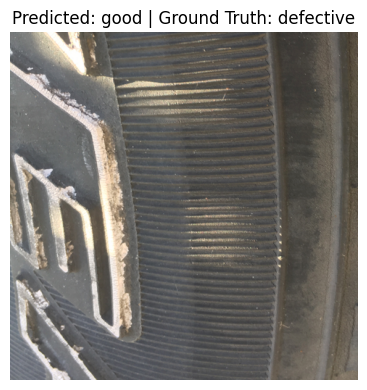

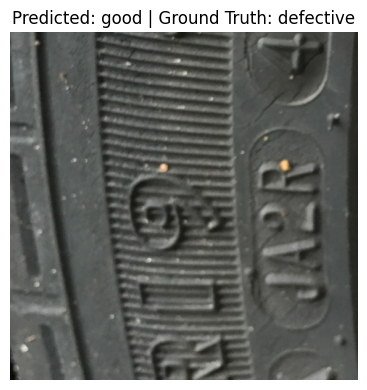

In [40]:
failed_image_gen = evaluation.failed_image_generator(
    final_model,
    test_dataloader,
    device,
    task="binary",
    threshold=0.5
)
evaluation.plot_failed_images_from_generator(
    failed_image_gen,
    class_names,
    transform=auto_transforms,
    max_images=10
)

In [44]:
class_names

['defective', 'good']

## Gradio Demo - Deployable App ▶️
We are going to create this folder structure for us to deploy Tyre Quality Checker to HuggingFace 🤗 Spaces

```
demos/
└── tyre_quality_checker/
    ├── pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

In [45]:
# Demos folder
import shutil
from pathlib import Path

tyre_quality_checker_demo_path = Path("demos/tyre_quality_checker/")

# Remove already existing files if there any and create new directory
if tyre_quality_checker_demo_path.exists():
    shutil.rmtree(tyre_quality_checker_demo_path)
    tyre_quality_checker_demo_path.mkdir(parents=True, exist_ok=True)
else:
    tyre_quality_checker_demo_path.mkdir(parents=True, exist_ok=True)

# Check
!ls demos/tyre_quality_checker/

In [46]:
# Examples
# Create an examples directory
tyre_quality_checker_examples_path = tyre_quality_checker_demo_path / "examples"
tyre_quality_checker_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
tyre_quality_checker_examples = [Path('data/test/good/good (112).jpg'),
                                 Path('data/test/good/good (124).jpg'),
                                 Path('data/test/good/good (15).jpg'),
                                 Path('data/test/defective/Defective (107).jpg'),
                                 Path('data/test/defective/Defective (131).jpg'),
                                 Path('data/test/defective/Defective (164).jpg'),
                                 Path('data/test/good/good (184).jpg')]

# Copy random images to the examples directory
for example in tyre_quality_checker_examples:
    destination = tyre_quality_checker_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)
    
# Check
!ls demos/tyre_quality_checker/examples

[INFO] Copying data/test/good/good (112).jpg to demos/tyre_quality_checker/examples/good (112).jpg
[INFO] Copying data/test/good/good (124).jpg to demos/tyre_quality_checker/examples/good (124).jpg
[INFO] Copying data/test/good/good (15).jpg to demos/tyre_quality_checker/examples/good (15).jpg
[INFO] Copying data/test/defective/Defective (107).jpg to demos/tyre_quality_checker/examples/Defective (107).jpg
[INFO] Copying data/test/defective/Defective (131).jpg to demos/tyre_quality_checker/examples/Defective (131).jpg
[INFO] Copying data/test/defective/Defective (164).jpg to demos/tyre_quality_checker/examples/Defective (164).jpg
[INFO] Copying data/test/good/good (184).jpg to demos/tyre_quality_checker/examples/good (184).jpg
'Defective (107).jpg'  'good (112).jpg'  'good (184).jpg'
'Defective (131).jpg'  'good (124).jpg'
'Defective (164).jpg'  'good (15).jpg'


In [47]:
# Model
pt_tyre_quality_EfficientNet_V2_L_model_path = "models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth"

pt_tyre_quality_EfficientNet_V2_L_model_destination = tyre_quality_checker_demo_path / pt_tyre_quality_EfficientNet_V2_L_model_path.split("/")[1]

try:
    print(f"[INFO] Attempting to move {pt_tyre_quality_EfficientNet_V2_L_model_path} to {pt_tyre_quality_EfficientNet_V2_L_model_destination}")

    # Move the model
    shutil.move(src=pt_tyre_quality_EfficientNet_V2_L_model_path,
                dst=pt_tyre_quality_EfficientNet_V2_L_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved
except:
    print(f"[INFO] No model found at {pt_tyre_quality_EfficientNet_V2_L_model_path}")
    print(f"[INFO] Model exists at {pt_tyre_quality_EfficientNet_V2_L_model_destination}: {pt_tyre_quality_EfficientNet_V2_L_model_destination.exists()}")

[INFO] Attempting to move models/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth to demos/tyre_quality_checker/pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth
[INFO] Model move complete.


In [ ]:
# model.py

In [61]:
%%writefile demos/tyre_quality_checker/model.py
import torch
import torchvision

from torch import nn

def create_effnet_v2_l_model(num_classes:int=2, seed:int=42):
    """Creates an EfficientNet_V2_L feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 2.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EfficientNet_V2_L feature extractor model.
        transforms (torchvision.transforms): EfficientNet_V2_L image transforms.
    """
    # Getting pre-trained model
    weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_l(weights=weights)

    # Get transforms
    transforms = weights.transforms()
    
    # Freeze features
    for param in model.features.parameters():
        param.requires_grad = False

    # Changing head
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=1280,
                      out_features=1,
                      bias=True),
        torch.nn.Sigmoid()
    )

    return model, transforms

Overwriting demos/tyre_quality_checker/model.py


In [ ]:
# app.py

In [75]:
%%writefile demos/tyre_quality_checker/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnet_v2_l_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['defective', 'good']

### 2. Model and transforms preparation ###
# Create EfficientNet_V2_L model
effnet_v2_l, effnet_v2_l_transforms = create_effnet_v2_l_model(
    num_classes=len(class_names)
)

# Load saved weights
effnet_v2_l.load_state_dict(
    torch.load(
        f="pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth",
        map_location=torch.device("cpu"),
    )
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    """
    Transforms and performs a prediction on img and returns prediction and time taken.
    """
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnet_v2_l_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnet_v2_l.eval()
    with torch.inference_mode():
        pred_probs = effnet_v2_l(img).item()

    # Create a prediction label and prediction probability dictionary for each prediction class
    # Required format for Gradio's output parameter
    pred_label = 1 if pred_probs >= 0.5 else 0
    pred_labels_and_probs = {'defective': 1 - pred_probs, 'good': pred_probs}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description, & article strings
title = "Vehicle Tyre Quality Checker 🏍️🚗🛞🔧🧑‍🔧"
description = """
An `EFFICIENTNET_V2_L` feature extractor Computer Vision model to predict vehicle (car, motorbike, etc) tyre condition as defective or good. Tyre cracks are signs of tyres getting older, and can mean defective vehicle tyres. This app uses tyre's images to predict defectives (80/20 train/test accuracy > 97%).

Dataset attribution:
- Title: Tyre Quality Classification
- Author: CHIRAG CHAUHAN
- Source: [Kaggle](https://www.kaggle.com/datasets/warcoder/tyre-quality-classification)
- License: This dataset is licensed under a Creative Commons Attribution 4.0 International License (CC BY 4.0). 
- License URL: https://creativecommons.org/licenses/by/4.0/
"""
article = "Created for my AI/ML portfolio [PaSathees/portfolio](https://github.com/PaSathees/portfolio)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=2, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/tyre_quality_checker/app.py


In [52]:
import gradio as gr
print(torch.__version__)
print(torchvision.__version__)
print(gr.__version__)

1.12.1+cu116
0.13.1+cu116
3.50.2


In [ ]:
# requirements.txt

In [53]:
%%writefile demos/tyre_quality_checker/requirements.txt
torch==1.12.1
torchvision==0.13.1
gradio==3.50.2

Writing demos/tyre_quality_checker/requirements.txt


In [73]:
!ls demos/tyre_quality_checker

__pycache__  model.py
app.py	     pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth
examples     requirements.txt


In [76]:
# zip the tyre_quality_checker folder
!cd demos/tyre_quality_checker && zip -r ../tyre_quality_checker.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 53%)
  adding: examples/ (stored 0%)
  adding: examples/Defective (107).jpg (deflated 2%)
  adding: examples/Defective (164).jpg (deflated 2%)
  adding: examples/good (15).jpg (deflated 1%)
  adding: examples/good (112).jpg (deflated 0%)
  adding: examples/good (184).jpg (deflated 0%)
  adding: examples/good (124).jpg (deflated 16%)
  adding: examples/Defective (131).jpg (deflated 0%)
  adding: model.py (deflated 58%)
  adding: pt_tyre_quality_EfficientNet_V2_L_bs_32_ep_30_lr_0.001.pth (deflated 6%)
  adding: requirements.txt (deflated 4%)


## App Embedding 🍾🎉🥂

In [77]:
from IPython.display import IFrame

IFrame(src="https://hf.space/embed/PaSathees/Vehicle_Tyre_Quality_Checker/+", width=900, height=750)

In [78]:
print("Happy AI Development, end of notebook")

Happy AI Development, end of notebook
